In [1]:
import numpy as np
import forward.common as common
import forward.homogeneous_semi_inf as hsi
import inverse.fit_homogeneous_semi_inf as fhsi
import matplotlib.pyplot as plt

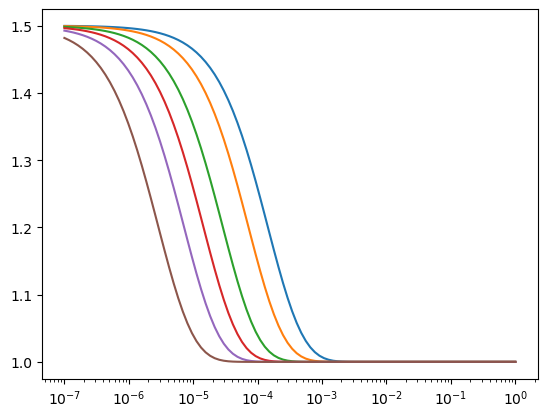

In [2]:
tau = np.logspace(-7, 0, 100)
lambda0 = 785
mua = 0.01
musp = 10
rho = 2
n = 1.4
db = [1e-9, 2e-9, 5e-9, 1e-8, 2e-8, 5e-8]
v_ms = [1e-5, 2e-5, 5e-5, 1e-4, 2e-4, 5e-4]
beta = 0.5
g1_norm = np.zeros((len(tau), len(db)))
g2_norm = np.zeros((len(tau), len(db)))
for i in range(len(db)):
    msd = common.msd_brownian(tau, db[i])
    g1_norm[:, i] = hsi.g1_norm(msd, mua, musp, rho, n, lambda0)

g2_norm = 1 + beta * g1_norm**2
plt.semilogx(tau, g2_norm)
plt.show()

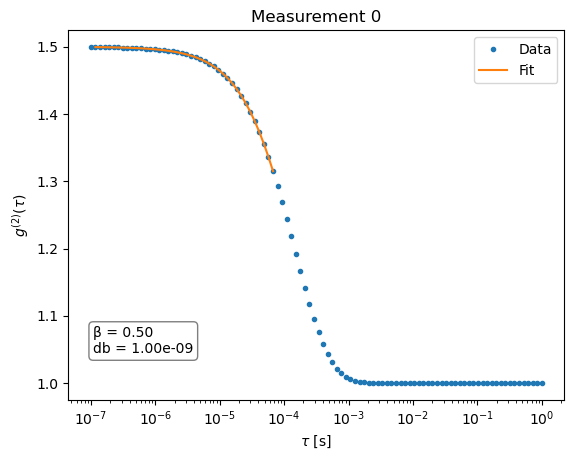

In [18]:
#beta_calculator =  fhsi.BetaCalculator(mode="fixed", beta_fixed=0.50)
beta_calculator = fhsi.BetaCalculator(mode="fit", beta_init=0.48, beta_bounds=(0.45, 0.6))
msd_model = fhsi.MSDModel(model_name="brownian", param_init={"db": 1e-8}, param_bounds={"db": (0, None)})
#msd_model = fhsi.MSDModel(model_name="ballistic", param_init={"v_ms": 1e-4}, param_bounds={"v_ms": (0, None)})
#msd_model = fhsi.MSDModel(model_name="hybrid", param_init={"db": 1e-8, "v_ms": 1e-4}, param_bounds={"db": (0, None), "v_ms": (0, None)})
fitter = fhsi.FitHomogeneousSemiInf(
    tau,
    g2_norm,
    mua,
    musp,
    rho,
    n,
    lambda0,
    msd_model,
    beta_calculator,
    tau_lims_fit=(1e-7, 1e-3),
    g2_lim_fit=1.3,
    plot_interval=100
)

fitted_data = fitter.fit()

In [19]:
fitted_data

,db,beta
0,9.999999e-10,0.5
1,2.000000e-09,0.5
2,4.999999e-09,0.5
3,1.000004e-08,0.5
4,2.000002e-08,0.5
5,5.000006e-08,0.5
